# Description

Seek to find the largest value of k up to which linear theory gives accurate results. Such value for kmax is found for each density bin separately. We use Markov Chain Monte Carlo to fit $b1$ and $\beta$. To assert if linear theory is accurate, we compare the inferred $f_0*\sigma_8$ to the true one.

The fitting process is layed out in `Fit_b1_beta_MCMC.ipynb`. Here we use the mock covariance matrix.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import legendre
import time

import inv_cov_funcs as icf
import cat_power_algos as catpk
import classylss
import fitsio
import zeus 
from nbodykit.lab import *
from nbodykit import style
plt.style.use(style.notebook)

In [3]:
LOS = [0,0,1]
redshift = 0
BoxSize = 2000
cosmo_paras = classylss.load_ini('/home/jwack/main/Planck18_LCDM.ini')
cosmo = cosmology.cosmology.Cosmology.from_dict(cosmo_paras)
Plin = cosmology.LinearPower(cosmo, redshift, transfer='CLASS')
sigma8_lin = Plin.sigma8
sigma8_true = 0.8111 
f0_true = cosmo.scale_independent_growth_rate(redshift)

dk = 0.01
ells = [0,2]

/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): sigma_8
  self.engine = ClassEngine(pars)


In [4]:
# load computed power spectra to deduce multipoles in each bin and P(k,mu) from data
k_full, shotnoise, n_ptile, Pk_ells_full = icf.load_power_data('/home/jwack/main/fit_linear_model_in_density_bins/', 
                                                               ells, get_data_Pkmus=False)
# for given BoxSize, k is NaN above 0.034
possible_kmax = k_full[k_full<=0.343][1:] # ignore first k bin 

In [5]:
def logprior(theta, i):
    ''' The natural logarithm of the prior probability. Assume parameters independent such that log priors add.
    Note that normalization is irrelevant for MCMC.'''
    lp = 0.
    b1, beta = theta
    # choose uniform priors for both parameters. 
    b1_min, b1_max = 0, 3
    if i == 0:
        beta_min, beta_max = -3, 3
    else:
        beta_min, beta_max = 0, 3
        
    lp_b1 = 0. if b1_min < b1 < b1_max else -np.inf
    lp_beta = 0. if beta_min < beta < beta_max else -np.inf
    
    return lp_b1 + lp_beta


def loglike(theta, data_multipoles, k, C_inv):
    '''Return logarithm of likelihood i.e. -0.5*chi2.
    data_multipoles must be an array of shape (len(ells), len(k)). theta is parameter vector: [b1, beta].
    Due to hard coding multipoles, only works for ells = [0,2] and purely linear Kaiser theory. Alternative described in 
    minimizing chi2 and ABC fitting notebooks.'''
    b1, beta = theta
    ells = [0,2]
    # make model vector
    model_multipoles = np.empty((len(ells), len(k)))
    model_multipoles[0] = (1 + 2/3*beta + 1/5*beta**2) * b1**2 * Plin(k)
    model_multipoles[1] = (4/3*beta + 4/7*beta**2) * b1**2 * Plin(k)
        
    D_M = (data_multipoles - model_multipoles).flatten()
    
    return -0.5*D_M@(C_inv @ D_M)


def logpost(theta, i, data_multipoles, k, C_inv):
    '''Returns the logarithm of the posterior. By Bayes' theorem, this is just the sum of the log prior and log likelihood (up 
    to a irrelavant constant).
    Uses values for theta from pre-analysis step to inform prior
    ''' 
    return logprior(theta, i) + loglike(theta, data_multipoles, k, C_inv)

In [8]:
# set range of kmax for which we compute delta_fs8 for each density bin. 
# exclude taking lowested k bin as kmax since that bin will be removed in slicing (negative quadrupole)
kmax_range = possible_kmax[1:11]
Nkmax = len(kmax_range)

chains = np.empty((n_ptile, Nkmax), dtype='object')

b1_fits, beta_fits, delta_fs8 = np.full((n_ptile, Nkmax), np.nan), np.full((n_ptile, Nkmax), np.nan), np.full((n_ptile, Nkmax), np.nan) 
b1_stds, beta_stds, delta_fs8_stds = np.full((n_ptile, Nkmax), np.nan), np.full((n_ptile, Nkmax), np.nan), np.full((n_ptile, Nkmax), np.nan)

reduced_chi2 = np.full((n_ptile, Nkmax), np.nan)

ndim = 2
nwalkers = 6 
nsteps = 1000

start = 0.5 + 1*np.random.random((nwalkers, ndim)) # initial positions: randomly choosen between 0.5 and 1.5 

print("Fitting up to kmax=%.3f"%kmax_range[-1])

for i in range(n_ptile):
    cov_mat = np.loadtxt('/home/jwack/main/bruteforce_covmat/covariance_matricies/cov_ptile_%d.txt'%i)
    t1 = time.time()
    for j,kmax in enumerate(kmax_range):
        # slice up to increasingly large kmax and find delta_fs8 for each bin
        mask = np.full(len(k_full), False)
        mask = k_full <= kmax
        mask[0] = False 
        k_sliced = k_full[mask]
        Pk_ells_i = Pk_ells_full[:,:,mask][i]
        
        C_inv = icf.mock_cov_mat_inv(cov_mat, k_full, kmax)
        sampler = zeus.EnsembleSampler(nwalkers, ndim, logpost, maxiter=1e5, verbose=False, args=[i, Pk_ells_i, k_sliced, C_inv]) 
        sampler.run_mcmc(start, nsteps)
        
        chain = sampler.get_chain(flat=True, discard=nsteps//2)
        chains[i][j] = chain # only needed when wanting to investigate chains later on
        
        b1_fits[i][j], b1_stds[i][j] = np.mean(chain[:,0]), np.std(chain[:,0]) 
        # parameter space is sym about b1=0 for Kaiser model. To get non negative fs8 assure that b1 and beta have the same sign
        if i == 0:
            b1_fits[i][j] *= -1
        beta_fits[i][j], beta_stds[i][j] = np.mean(chain[:,1]), np.std(chain[:,1])
        delta_fs8[i][j] = 1 - sigma8_lin*(beta_fits[i][j]*b1_fits[i][j])/(f0_true*sigma8_true)
        delta_fs8_stds[i][j] = np.abs(sigma8_lin/(f0_true*sigma8_true)*(beta_stds[i][j]*b1_fits[i][j]+beta_fits[i][j]*b1_stds[i][j]))        
        
        reduced_chi2[i][j] = -2*loglike([b1_fits[i][j], beta_fits[i][j]], Pk_ells_i, k_sliced, C_inv) / (2*len(k_sliced)-2)
        
    t2 = time.time()
    print('Fitted %d-th percentile in %.2f sec'%(i,t2-t1))

Fitting up to kmax=0.115


Sampling progress : 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.74it/s]


Fitted 0-th percentile in 116.27 sec


Sampling progress : 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.15it/s]


Fitted 1-th percentile in 80.47 sec


Sampling progress : 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.27it/s]


Fitted 2-th percentile in 73.12 sec


Sampling progress : 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.33it/s]


Fitted 3-th percentile in 73.98 sec


Sampling progress : 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.09it/s]


Fitted 4-th percentile in 73.16 sec


Sampling progress : 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.59it/s]


Fitted 5-th percentile in 74.31 sec


Sampling progress : 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 118.02it/s]


Fitted 6-th percentile in 71.48 sec


Sampling progress : 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.84it/s]


Fitted 7-th percentile in 72.17 sec


Sampling progress : 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.70it/s]


Fitted 8-th percentile in 73.23 sec


Sampling progress : 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.37it/s]

Fitted 9-th percentile in 77.35 sec


Repeat computation for full (not density binned) power spectrum. Since the mock covariance matrix was only computed for individual density bins, we use Gaussian covariance with Pkmu inferred from the data. See eq 24 of Grieb et al. 2016: https://arxiv.org/pdf/1509.04293.pdf.

In [10]:
full_delta_fs8, full_delta_fs8_stds = np.full(Nkmax, np.nan), np.full(Nkmax, np.nan)

r = FFTPower.load('density_bins/all_bins.json')

for i,kmax in enumerate(kmax_range):
    mask = np.full(len(k_full), False)
    mask = k_full <= kmax
    mask[0] = False 
    k_sliced = k_full[mask]
    
    Pk_0, Pk_2 = r.poles['power_0'].real-r.attrs['shotnoise'], r.poles['power_2'].real
    Pk_ells = np.row_stack([Pk_0, Pk_2])[:,mask]
    mus = r.power.coords['mu']
    Pkmu_data = (np.outer(Pk_0, legendre(0)(mus)) + np.outer(Pk_2, legendre(2)(mus)))[mask]
    
    C_inv = icf.gaussian_cov_mat_inv(k_sliced, ells, BoxSize, r.attrs['shotnoise'], 0.01, Pkmu_data, mus)
    sampler = zeus.EnsembleSampler(nwalkers, ndim, logpost, maxiter=1e5, verbose=False, args=[-1, Pk_ells, k_sliced, C_inv]) 
    sampler.run_mcmc(start, nsteps)

    chain = sampler.get_chain(flat=True, discard=nsteps//2)

    full_delta_fs8[i] = 1 - sigma8_lin*(np.mean(chain[:,1])*np.mean(chain[:,0]))/(f0_true*sigma8_true)
    full_delta_fs8_stds[i] = np.abs(sigma8_lin/(f0_true*sigma8_true)*(np.std(chain[:,1])*np.mean(chain[:,0])+np.mean(chain[:,1])*np.std(chain[:,0])))

Sampling progress : 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.13it/s]


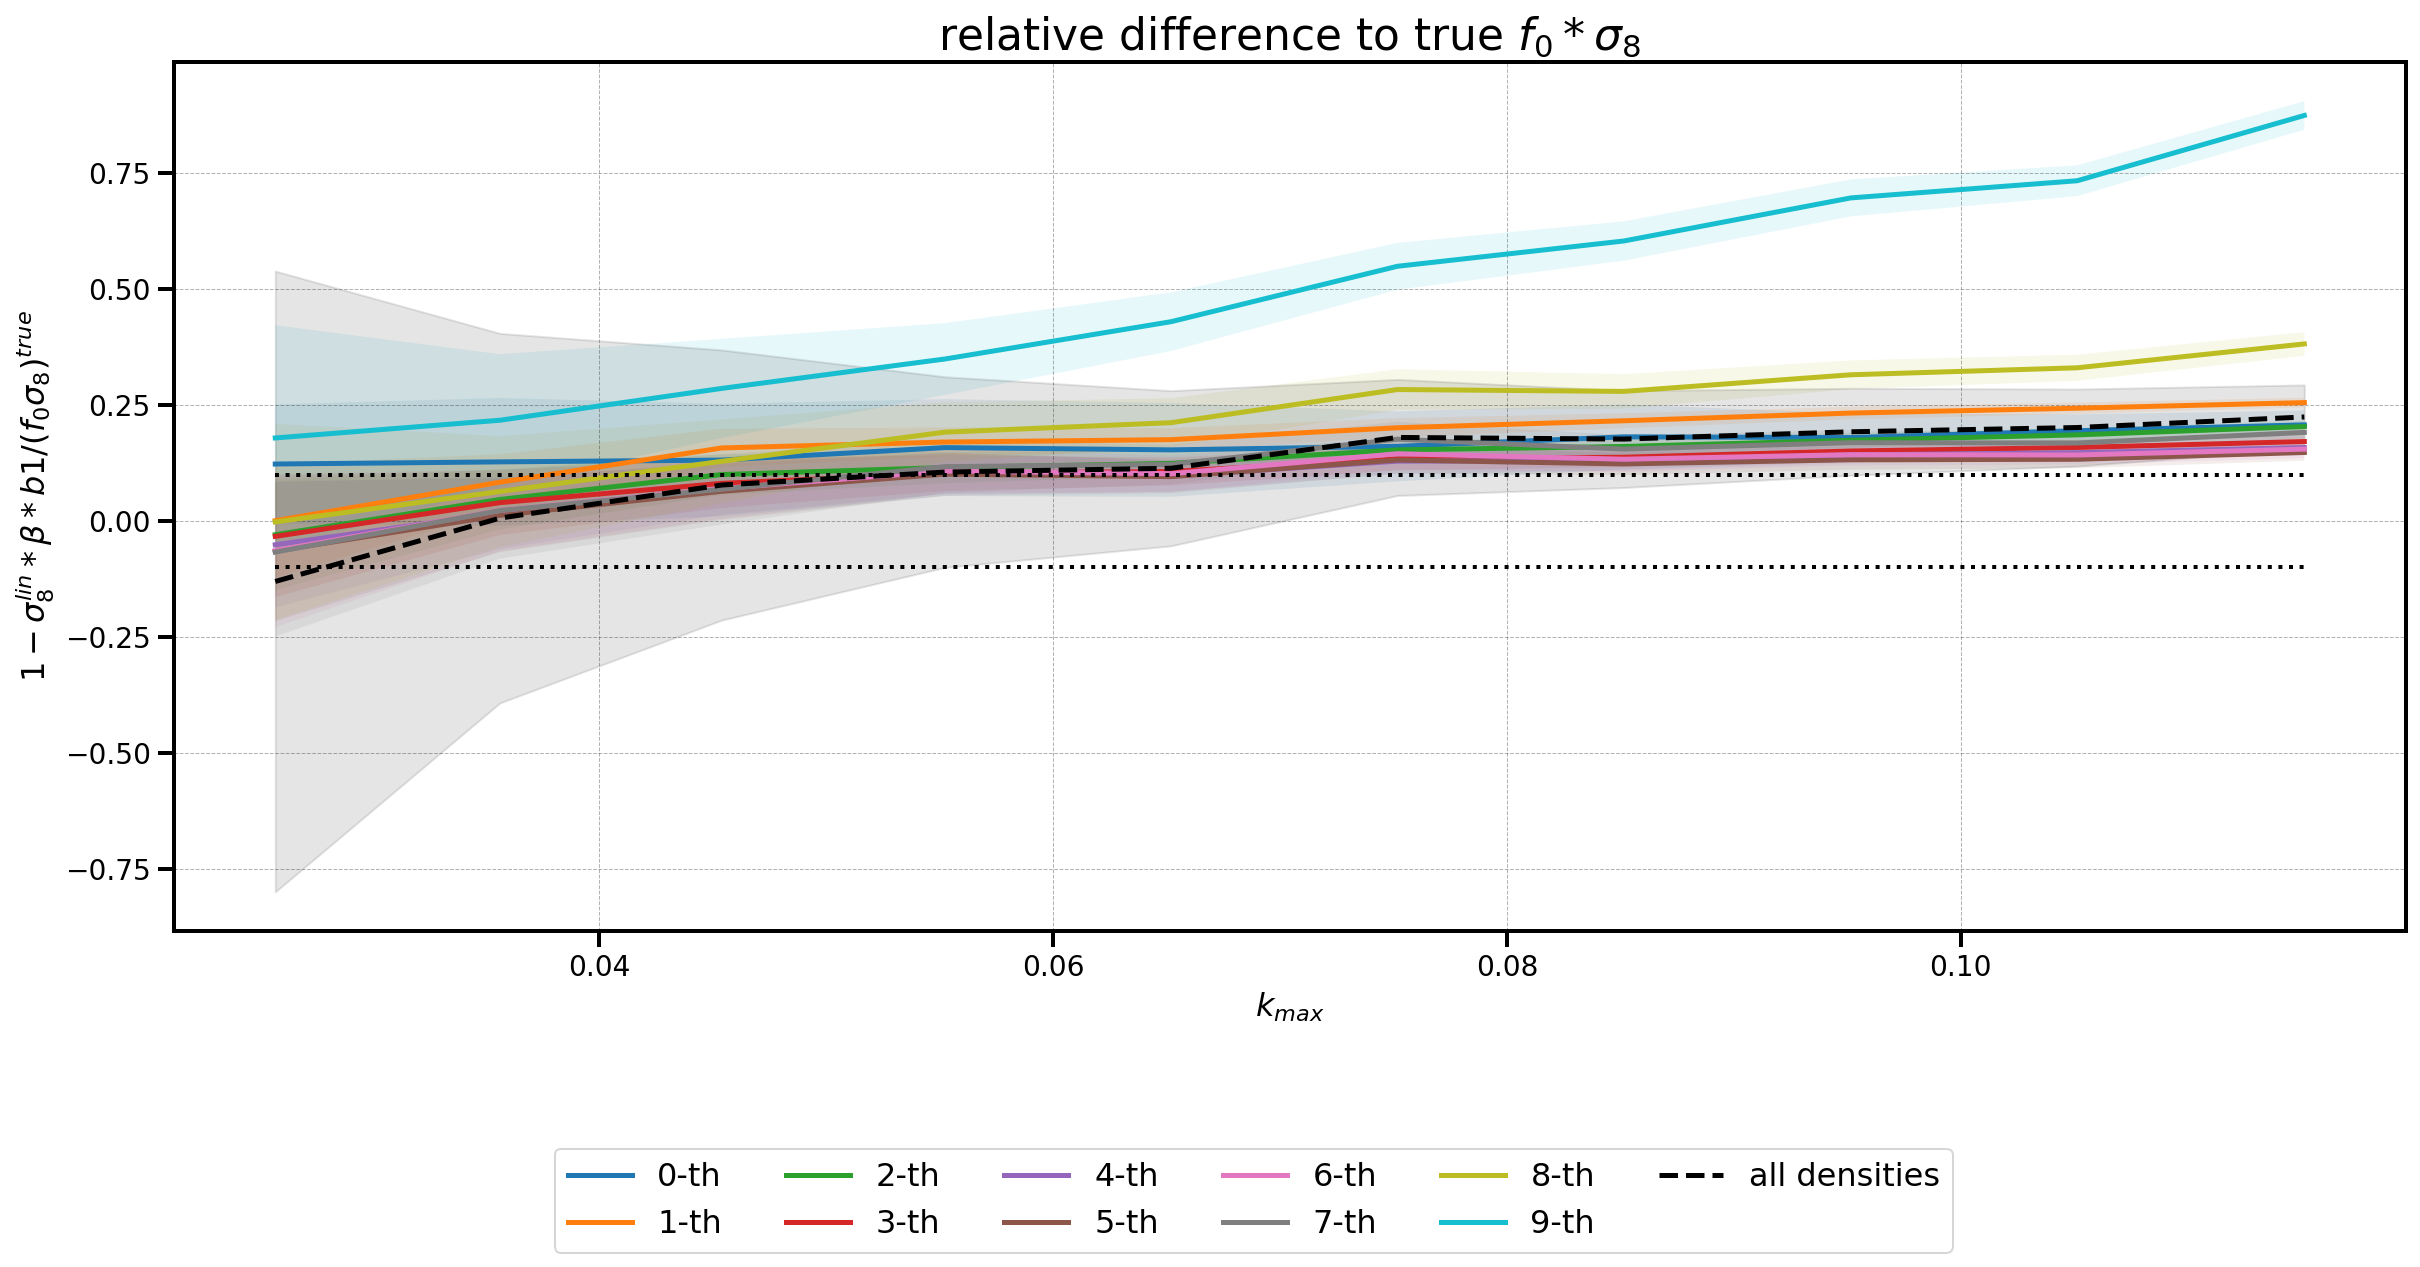

In [16]:
fig = plt.figure(figsize=(20,8))

for i in range(n_ptile):
    plt.plot(kmax_range, delta_fs8[i], label='%d-th'%i)
    plt.fill_between(kmax_range, delta_fs8[i]-delta_fs8_stds[i,:], delta_fs8[i]+delta_fs8_stds[i,:], alpha=0.1)
    
plt.plot(kmax_range, full_delta_fs8, '--', label='all densities', c='k')
plt.fill_between(kmax_range, full_delta_fs8-full_delta_fs8_stds, full_delta_fs8+full_delta_fs8_stds, color='k', alpha=0.1)
    
# add 10% diviation lines
plt.hlines([-0.1, 0.1], kmax_range[0], kmax_range[-1], linestyle='dotted', color='k', linewidth=2)

plt.title(r'relative difference to true $f_0*\sigma_8$')
plt.xlabel(r'$k_{max}$')
plt.ylabel(r'$1 - \sigma_8^{lin}*\beta*b1/(f_0\sigma_8)^{true}$')

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=6)
plt.show()

#fig.savefig('plots/d_fs8_vs_kmax.pdf')

### Interpretation
As observed in previous analysis steps, bins of extreme density are more difficult to fit than the middle density bins.
#### lowest density bin
For priors `Uniform(0,3)` for both parameters, we cannot estimate fs8 for the lowest bin at any kmax. The reason is that beta is fitted to $\beta=0$ which forces $fs8=0$, leading to a relative difference of 1. Recall from the chi2 minimization notebook that for this bin, beta is actually fitted negative if one doesn't constrain the parameter. Hence we relax the prior of beta but in order to obtain a positive fs8, b1 and beta must carry the same sign. Hence we relax both priors to `Uniform(-3,3)` which produces a non-zero fs8. However, when plotting the posteriors we find beta to have a dominate peak at $\beta=-1.2$ and a secondary peak of approximately half the amplitude at $\beta=-1.5$. b1 has symmetric peaks at $b1=\pm0.3$ such that each walker probes one of them with a 50/50 change causing the walker plot to be a step function. Constraining beta further to exclude the secondary peak resolves the issue in b1 as well. 

In [ ]:
chain = chains[0][-1]

In [ ]:
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(chain[:,n], alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = zeus.cornerplot(chain.reshape((-1,ndim), order='F'), labels=[r'$b1$', r'$\beta$']);